In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/DS/Practice/MRCNN

/content/drive/My Drive/DS/Practice/MRCNN


In [ ]:
!pip install tensorflow-gpu==1.15.3
!pip install keras==2.2.4

#Import Lib

In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [5]:
KANGAROO_DIR = os.path.join(ROOT_DIR, "datasets/kangaroo")

#Configurations

In [6]:
import os
import xml.etree
from numpy import zeros, asarray

import mrcnn.utils
import mrcnn.config
import mrcnn.model

class KangarooConfig(mrcnn.config.Config):
    NAME = "kangaroo_cfg"
    # GPU_COUNT = 1
    # IMAGES_PER_GPU = 2
    
    # NUM_CLASSES = 2

    STEPS_PER_EPOCH = 131
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 1+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    
    # Learning rate
    LEARNING_RATE=0.006
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10
   

In [7]:
# prepare config
kangaroo_config = KangarooConfig()
kangaroo_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

#Prepare Dataset

In [8]:
class KangarooDataset(mrcnn.utils.Dataset):

	def load_dataset(self, dataset_dir, is_train=True):
		self.add_class("dataset", 1, "kangaroo")

		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'

		for filename in os.listdir(images_dir):
			image_id = filename[:-4]

			if image_id in ['00090']:
				continue

			if is_train and int(image_id) >= 150:
				continue

			if not is_train and int(image_id) < 150:
				continue

			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'

			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		tree = xml.etree.ElementTree.parse(filename)

		root = tree.getroot()

		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)

		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		info = self.image_info[image_id]
		path = info['annotation']
		boxes, w, h = self.extract_boxes(path)
		masks = zeros([h, w, len(boxes)], dtype='uint8')

		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
		return masks, asarray(class_ids, dtype='int32')

In [9]:
# prepare train set
train_set = KangarooDataset()
train_set.load_dataset(dataset_dir=KANGAROO_DIR, is_train=True)
train_set.prepare()

# prepare test/val set
valid_dataset = KangarooDataset()
valid_dataset.load_dataset(dataset_dir=KANGAROO_DIR, is_train=False)
valid_dataset.prepare()

#Display some samples

Load and display image and masks

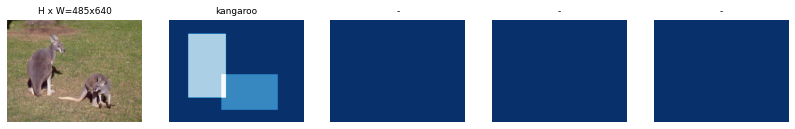

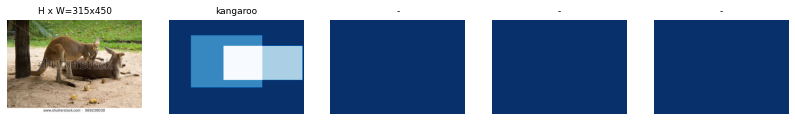

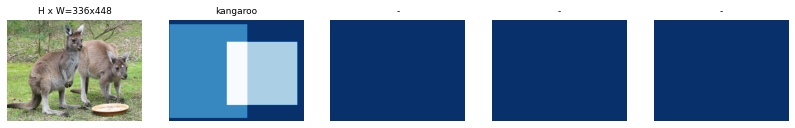

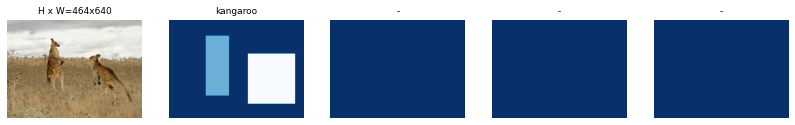

In [10]:
# Load and display random samples
image_ids = np.random.choice(train_set.image_ids, 4)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

#Bounding boxes

image_id  13 
image                    shape: (450, 600, 3)         min:    0.00000  max:  221.00000  uint8
mask                     shape: (450, 600, 1)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   15.00000  max:  565.00000  int32


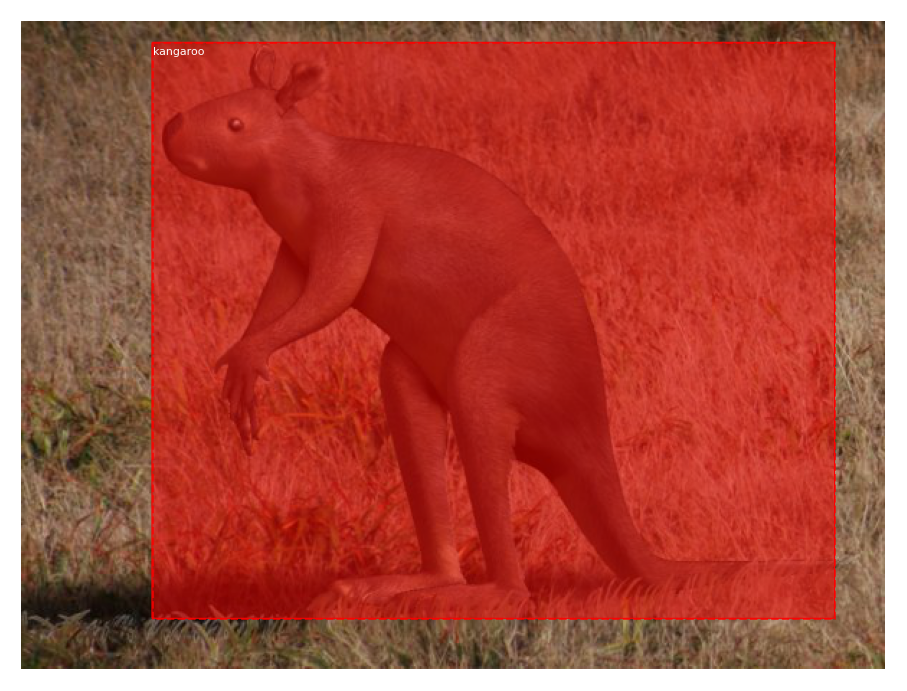

In [ ]:
# Load random image and mask.
image_id = random.choice(train_set.image_ids)
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, train_set.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names)

#Resize Image

image_id:  129 
Original shape:  (428, 750, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  265.00000  max:  957.00000  int32


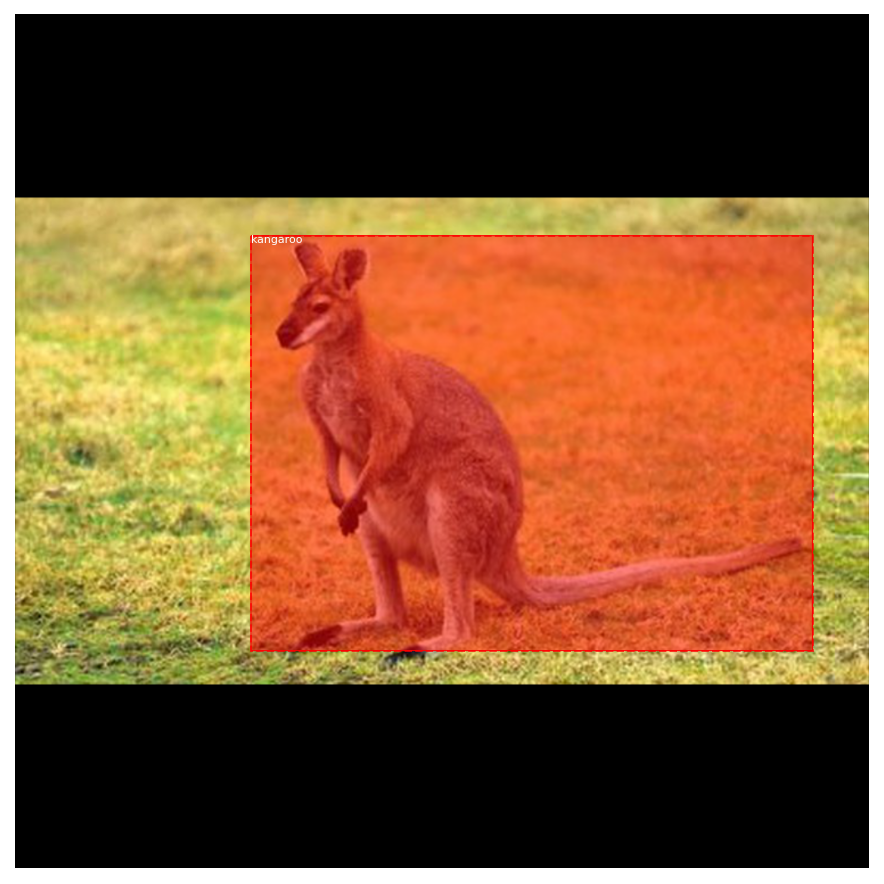

In [ ]:
# Load random image and mask.
image_id = np.random.choice(train_set.image_ids, 1)[0]
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=kangaroo_config.IMAGE_MIN_DIM, 
    max_dim=kangaroo_config.IMAGE_MAX_DIM,
    mode=kangaroo_config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, train_set.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names)

#Mini Mask

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
class_ids                shape: (2,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (2, 4)                min:  260.00000  max:  763.00000  int32
mask                     shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  uint8


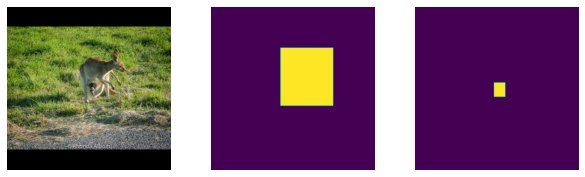

In [ ]:
image_id = np.random.choice(train_set.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    train_set, kangaroo_config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

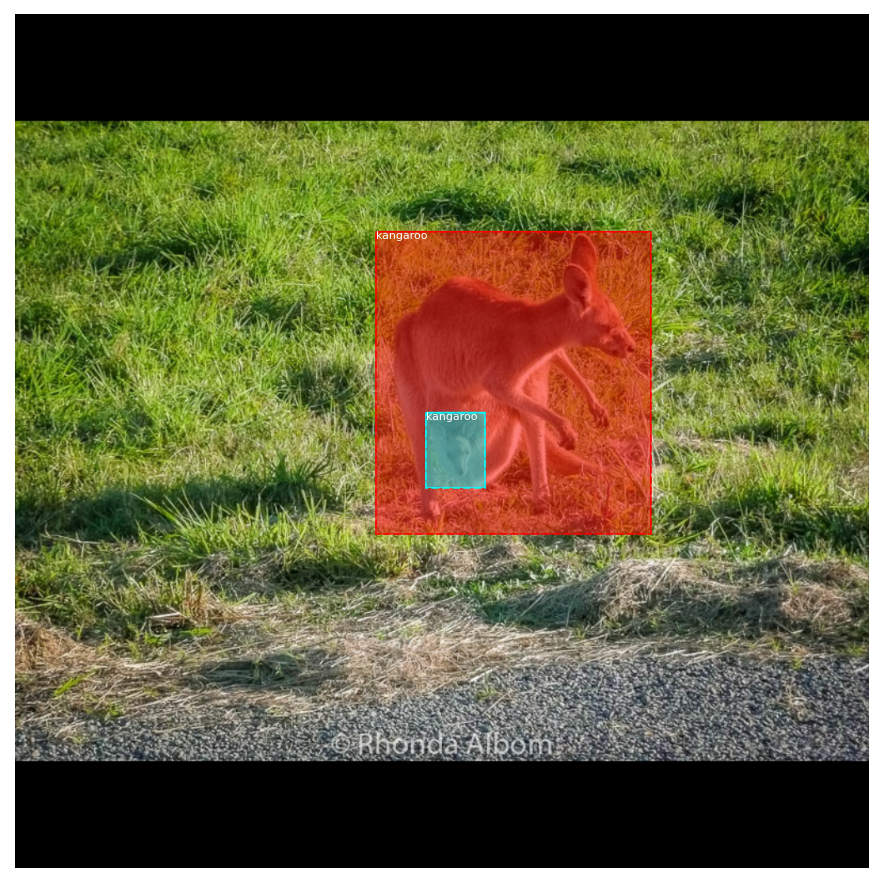

In [ ]:
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names)

#Create Model

In [118]:
model = modellib.MaskRCNN(mode='training', 
                             model_dir=MODEL_DIR,
                            config=kangaroo_config)

In [119]:
model.load_weights(COCO_MODEL_PATH,
                   by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

#Train Model

In [ ]:
model.train(train_dataset=train_set, 
            val_dataset=valid_dataset, 
            learning_rate=kangaroo_config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')

#Save weights

In [121]:
model_path = '/content/drive/My Drive/DS/Practice/MRCNN/Kangaroo_Detection/custom5_kangaroo_model.h5'
model.keras_model.save_weights(model_path)

#Visualize loss

In [ ]:
model.keras_model.history.history.keys()

dict_keys(['val_loss', 'val_rpn_class_loss', 'val_rpn_bbox_loss', 'val_mrcnn_class_loss', 'val_mrcnn_bbox_loss', 'val_mrcnn_mask_loss', 'loss', 'rpn_class_loss', 'rpn_bbox_loss', 'mrcnn_class_loss', 'mrcnn_bbox_loss', 'mrcnn_mask_loss'])

2 epochs

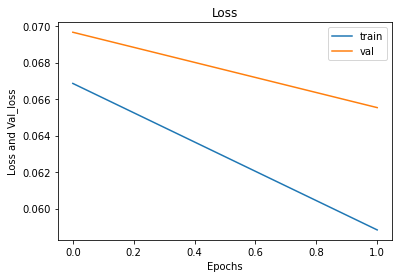

In [15]:
fig = plt.figure()
#plot loss and val_loss
plt.plot(model.keras_model.history.history['val_mrcnn_class_loss'])
plt.plot(model.keras_model.history.history['mrcnn_class_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss and Val_loss')
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

5 epochs

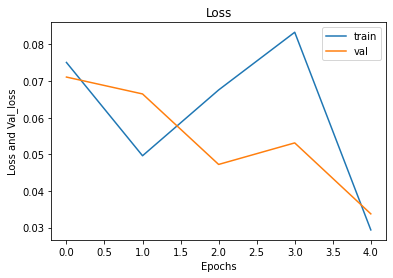

In [64]:
fig = plt.figure()
#plot loss and val_loss
plt.plot(model.keras_model.history.history['val_mrcnn_class_loss'])
plt.plot(model.keras_model.history.history['mrcnn_class_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss and Val_loss')
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

#Load weights

In [131]:
# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = modellib.MaskRCNN(mode="inference", 
                             config=kangaroo_config,
                             model_dir=MODEL_DIR)

# loading the trained weights on the custom dataset
model.load_weights(model_path, by_name=True)

#Predict

#1

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  410.00000  max:  901.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


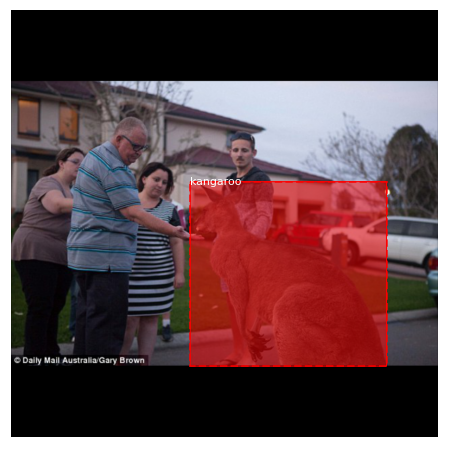

In [171]:
# Test on a random image
image_id = random.choice(valid_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, kangaroo_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            valid_dataset.class_names, figsize=(8, 8))

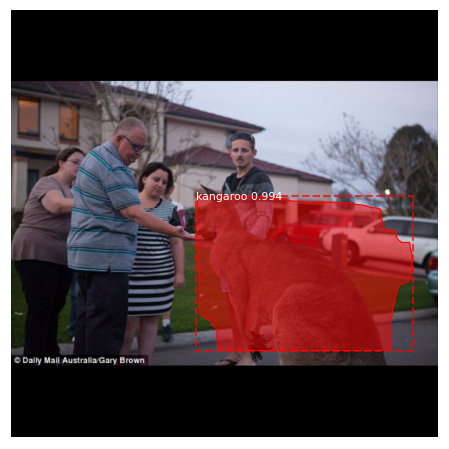

In [172]:
# Perform a forward pass of the network to obtain the results
r = model.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=valid_dataset.class_names,
                                  scores=r['scores'],
                                  figsize=(8, 8))

#2

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  251.00000  max:  794.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  uint8


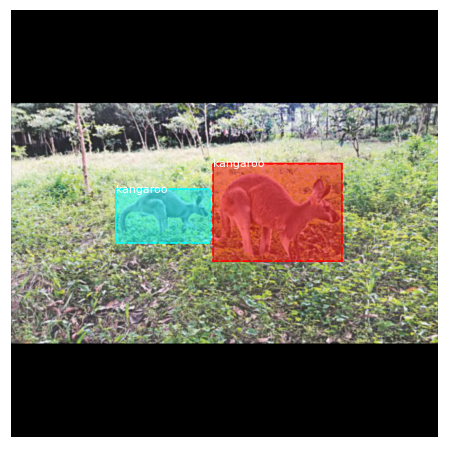

In [19]:
# Test on a random image
image_id = random.choice(valid_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, kangaroo_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            valid_dataset.class_names, figsize=(8, 8))

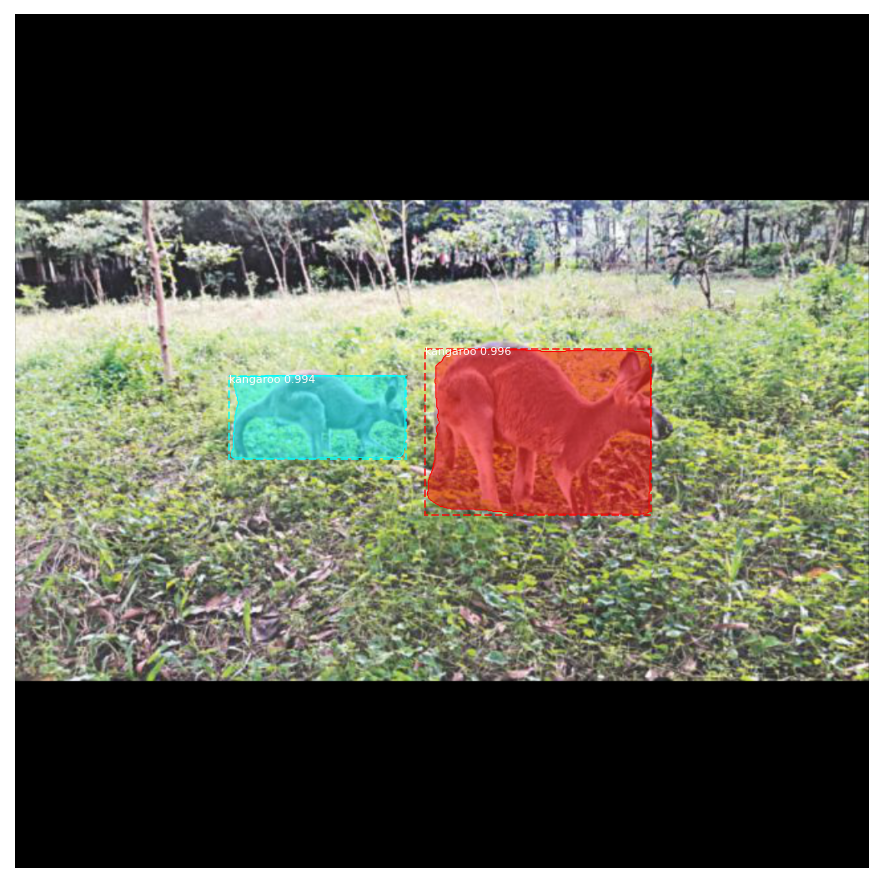

In [20]:
# Perform a forward pass of the network to obtain the results
r = model.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=valid_dataset.class_names,
                                  scores=r['scores'])

#3

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:    1.00000  max:  907.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  uint8


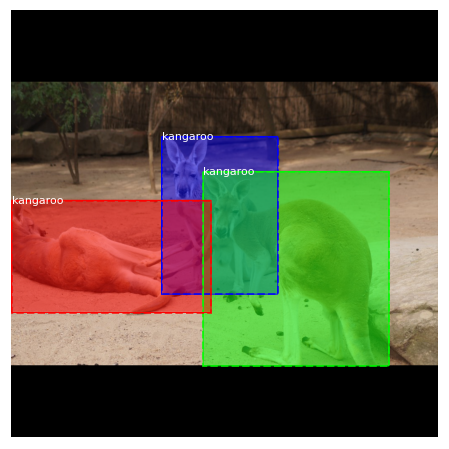

In [144]:
# Test on a random image
image_id = random.choice(valid_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, kangaroo_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            valid_dataset.class_names, figsize=(8, 8))

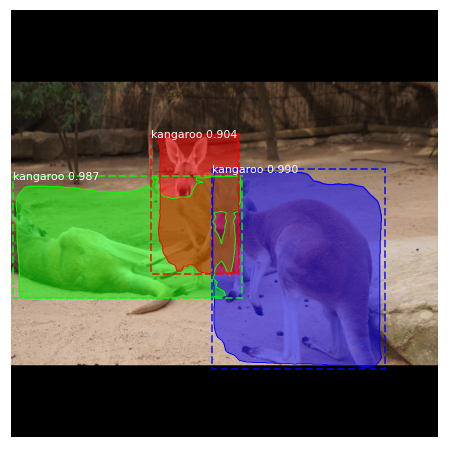

In [145]:
# Perform a forward pass of the network to obtain the results
r = model.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=valid_dataset.class_names,
                                  scores=r['scores'],
                                  figsize=(8, 8))

#4

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:   28.00000  max:  855.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  uint8


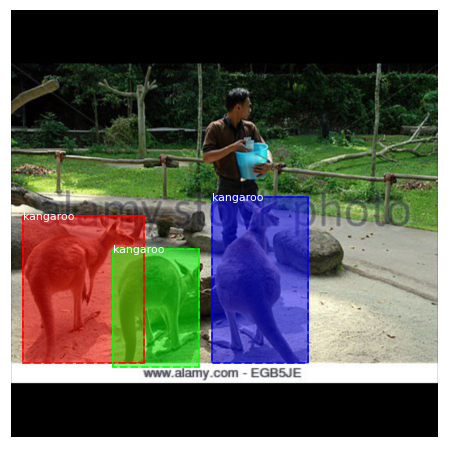

In [178]:
# Test on a random image
image_id = random.choice(valid_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, kangaroo_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            valid_dataset.class_names, figsize=(8, 8))

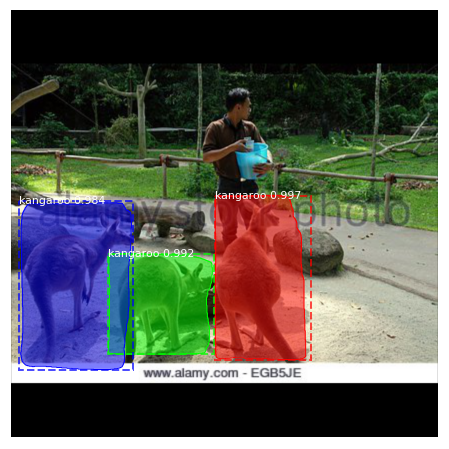

In [179]:
# Perform a forward pass of the network to obtain the results
r = model.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=valid_dataset.class_names,
                                  scores=r['scores'],
                                  figsize=(8, 8))

#5

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  239.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (5,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (5, 4)                min:    7.00000  max:  973.00000  int32
gt_mask                  shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  uint8


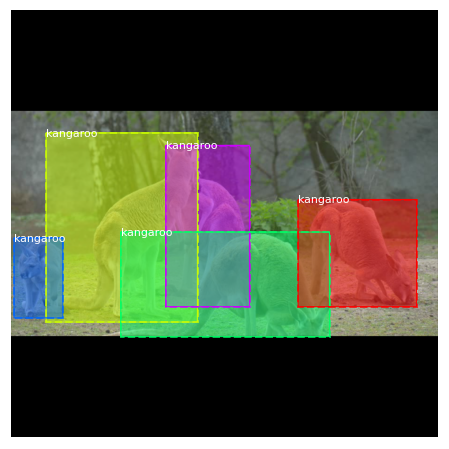

In [168]:
# Test on a random image
image_id = random.choice(valid_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, kangaroo_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            valid_dataset.class_names, figsize=(8, 8) )

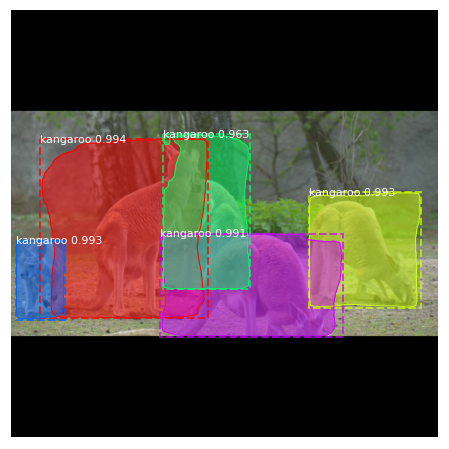

In [169]:
# Perform a forward pass of the network to obtain the results
r = model.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=valid_dataset.class_names,
                                  scores=r['scores'],
                                  figsize=(8, 8))

#Evaluate

In [117]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 30 images. Increase for better accuracy.
image_ids = np.random.choice(valid_dataset.image_ids, 30)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(valid_dataset, kangaroo_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, kangaroo_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9388888895511627
